In [1]:
# # 그래픽 카드 둘로 쓰기 (두개 있을때, 하나만 있다면 0)
# # gpu idx 를 0 또는 1 로 설정하시오
# import tensorflow as tf 
# import os

# os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # gpu idx

# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

In [2]:
# from tensorflow.python.client import device_lib 
# import tensorflow as tf 

# with tf.device('/device:GPU:1'):
#     print(device_lib.list_local_devices())

In [3]:
# 경로에 폴더가 없으면 폴더 만들기
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [4]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
import itertools
import pathlib
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

EPOCH = 100
KERNEL_SIZE = 3
BATCH_SIZE = 128
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

DATA_PATH = "./graph_data/"

def list_to_list(input_list):
    input_list_to_list = list(itertools.chain(*input_list))
    return input_list_to_list

# 데이터 불러오기

In [5]:
data_dir = pathlib.Path(DATA_PATH)
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

f = list(data_dir.glob('F/*'))
n = list(data_dir.glob('N/*'))
q = list(data_dir.glob('Q/*'))
s = list(data_dir.glob('S/*'))
v = list(data_dir.glob('V/*'))

graph_data
112599


# 데이터 split
## train, test, validation data 나누기

In [6]:
parents_path = DATA_PATH

In [7]:
parents_path = DATA_PATH
child_path = os.listdir(parents_path)

npy_check_list = []

temp_converted_img = list()
temp_ann_list = list()
X = list()
y = list()

for pic_path in (child_path):
    current_path = os.listdir(parents_path + pic_path)
    print("[INFO] Current path : " + parents_path + pic_path)
    for file_name in tqdm(current_path):
        path_for_array = parents_path + pic_path + "/" + file_name

        img = cv2.imread(path_for_array)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resize = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_AREA)
        temp_converted_img.append(img_resize / 255.0)
        
        check_ann = pic_path
        
        if check_ann == "N":            # Normal
            temp_ann_list.append([1, 0, 0, 0, 0])
        
        elif check_ann == "S":          # Supra-ventricular
            temp_ann_list.append([0, 1, 0, 0, 0])
        
        elif check_ann == "V":          # Ventricular
            temp_ann_list.append([0, 0, 1, 0, 0])
        
        elif check_ann == "F":          # False alarm
            temp_ann_list.append([0, 0, 0, 1, 0])
        
        else:                           # Unclassed 
            temp_ann_list.append([0, 0, 0, 0, 1])
    
        y.append(temp_ann_list)

[INFO] Current path : ./graph_data/F


100%|██████████| 803/803 [00:06<00:00, 133.36it/s]


[INFO] Current path : ./graph_data/N


100%|██████████| 90631/90631 [10:21<00:00, 145.72it/s]


[INFO] Current path : ./graph_data/Q


100%|██████████| 11148/11148 [01:19<00:00, 140.69it/s]


[INFO] Current path : ./graph_data/S


100%|██████████| 2781/2781 [00:19<00:00, 140.70it/s]


[INFO] Current path : ./graph_data/V


100%|██████████| 7236/7236 [00:51<00:00, 140.21it/s]


In [8]:
onehot_y = np.array(temp_ann_list)
temp_converted_img = np.array(temp_converted_img)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(temp_converted_img, onehot_y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

print("[SIZE]\t\tNpX lenght : {}\n\t\tNpY length : {}".format(X_train.shape, y_train.shape))
print("[SIZE]\t\tX_validation length : {}\n\t\ty_validation length : {}".format(X_val.shape, y_val.shape))
print("[SIZE]\t\tX_test length : {}\n\t\ty_test length : {}".format(X_test.shape, y_test.shape))

[SIZE]		NpX lenght : (75441, 128, 128)
		NpY length : (75441, 5)
[SIZE]		X_validation length : (12263, 128, 128)
		y_validation length : (12263, 5)
[SIZE]		X_test length : (24895, 128, 128)
		y_test length : (24895, 5)


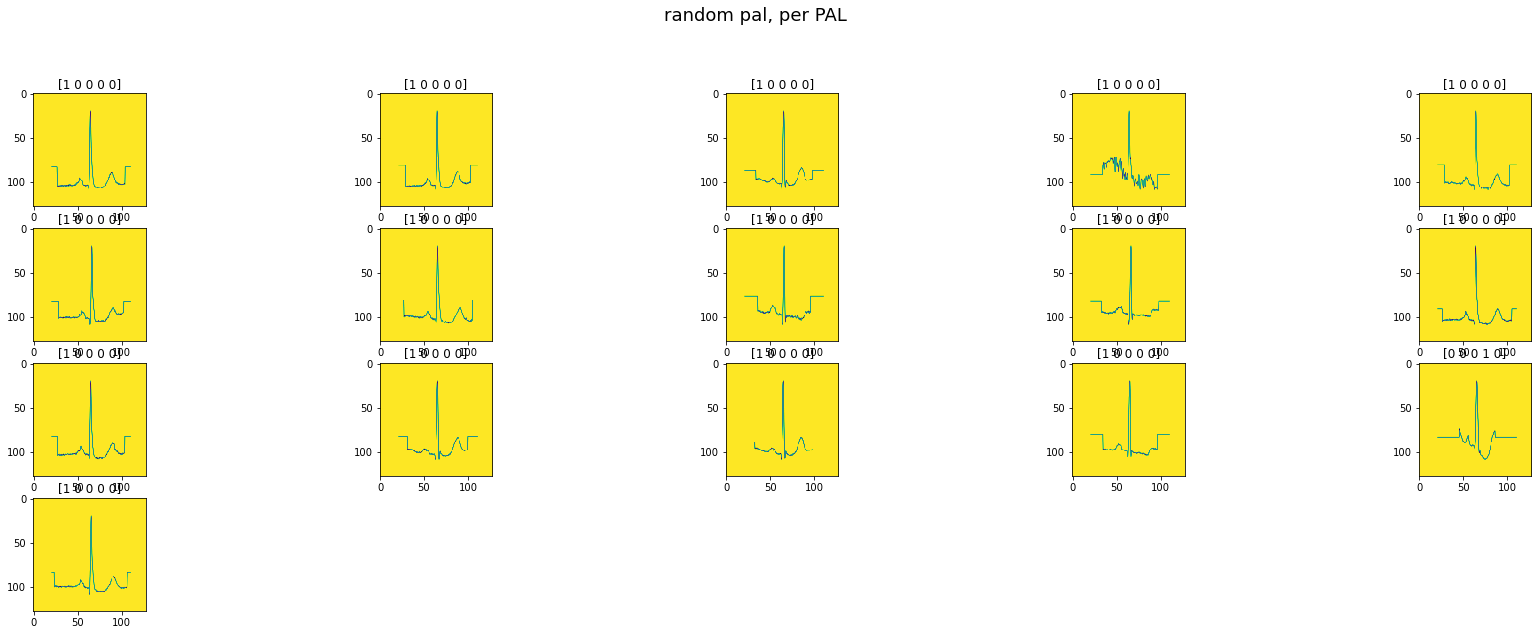

In [10]:
# 랜덤으로 뽑아서 뿌려보기

import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(30, 12))
plt.suptitle("random pal, per PAL", fontsize=18)
n = 0
random.seed(11)
for i in random.sample(range(6480), 16):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(temp_converted_img[i] * 255.0, interpolation='nearest')
    ax.set_title(str(onehot_y[i]))
    n+=1

# 모델 생성

In [57]:
input_size = (128, 128, 1)

# models = keras.Sequential([
#     # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_size),
#     layers.MaxPool2D(pool_size=(2, 2), strides=2),

#     layers.Conv2D(128, kernel_size=(2, 2), activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2), strides=2),

#     layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2), strides=2),

#     layers.Conv2D(512, kernel_size=(2, 2), activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2), strides=2),

#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(4096, activation='relu'),
#     layers.Dense(5, activation='softmax')
# ])

kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

def inception(x, filters_1, filters_1to3, filters_3, filters_1to5, filters_5, filters_pool_proj, kernel_init=kernel_init, bias_init=bias_init):
    conv_1      = layers.Conv2D(filters_1,      (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_1to3   = layers.Conv2D(filters_1to3,   (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3      = layers.Conv2D(filters_3,      (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_1to3)
    
    conv_1to5   = layers.Conv2D(filters_1to5,   (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5      = layers.Conv2D(filters_5,      (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_1to5)
    
    max_pool    = layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool_proj   = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(max_pool)
    
    output      = layers.concatenate([conv_1, conv_3, conv_5, pool_proj])
    return output

input_layer = layers.Input(shape=(128, 128, 1))

x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = layers.MaxPool2D(   pool_size=(3, 3), strides=2, padding='same')(x)
x = layers.Conv2D(64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = layers.Conv2D(192,kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = layers.MaxPool2D(   pool_size=(3, 3), strides=2, padding='same')(x)

x = inception(x, 64, 96, 128, 16, 32, 32)
x = inception(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPool2D(pool_size=(3, 3), strides=2)(x)

x = inception(x, 192, 96, 208, 16, 48, 64)

x1 = layers.AveragePooling2D(pool_size=(5, 5), strides=3)(x)
x1 = layers.Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1) #0.7
x1 = layers.Dense(5, activation='softmax', name='aux_1')(x1)

x = inception(x, 160, 112, 224, 24, 64, 64)
x = inception(x, 128, 128, 256, 24, 64, 64)
x = inception(x, 112, 144, 288, 32, 64, 64)

x2 = layers.AveragePooling2D(pool_size=(5, 5), strides=3)(x)
x2 = layers.Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2) #0.7
x2 = layers.Dense(5, activation='softmax', name='aux_2')(x2)

x = inception(x, 256, 160, 320, 32, 128, 128)
x = layers.MaxPool2D(pool_size=(3, 3), strides=2)(x)

x = inception(x, 256, 160, 320, 32, 128, 128)
x = inception(x, 384, 192, 384, 48, 128, 128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) #0.4
x = layers.Dense(5, activation='softmax', name='final')(x)

googleNet = keras.Model(input_layer, [x, x1, x2])

In [59]:
googleNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 64, 64, 64)   3200        ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 32, 32, 64)  0           ['conv2d_77[0][0]']              
 )                                                                                                
                                                                                            

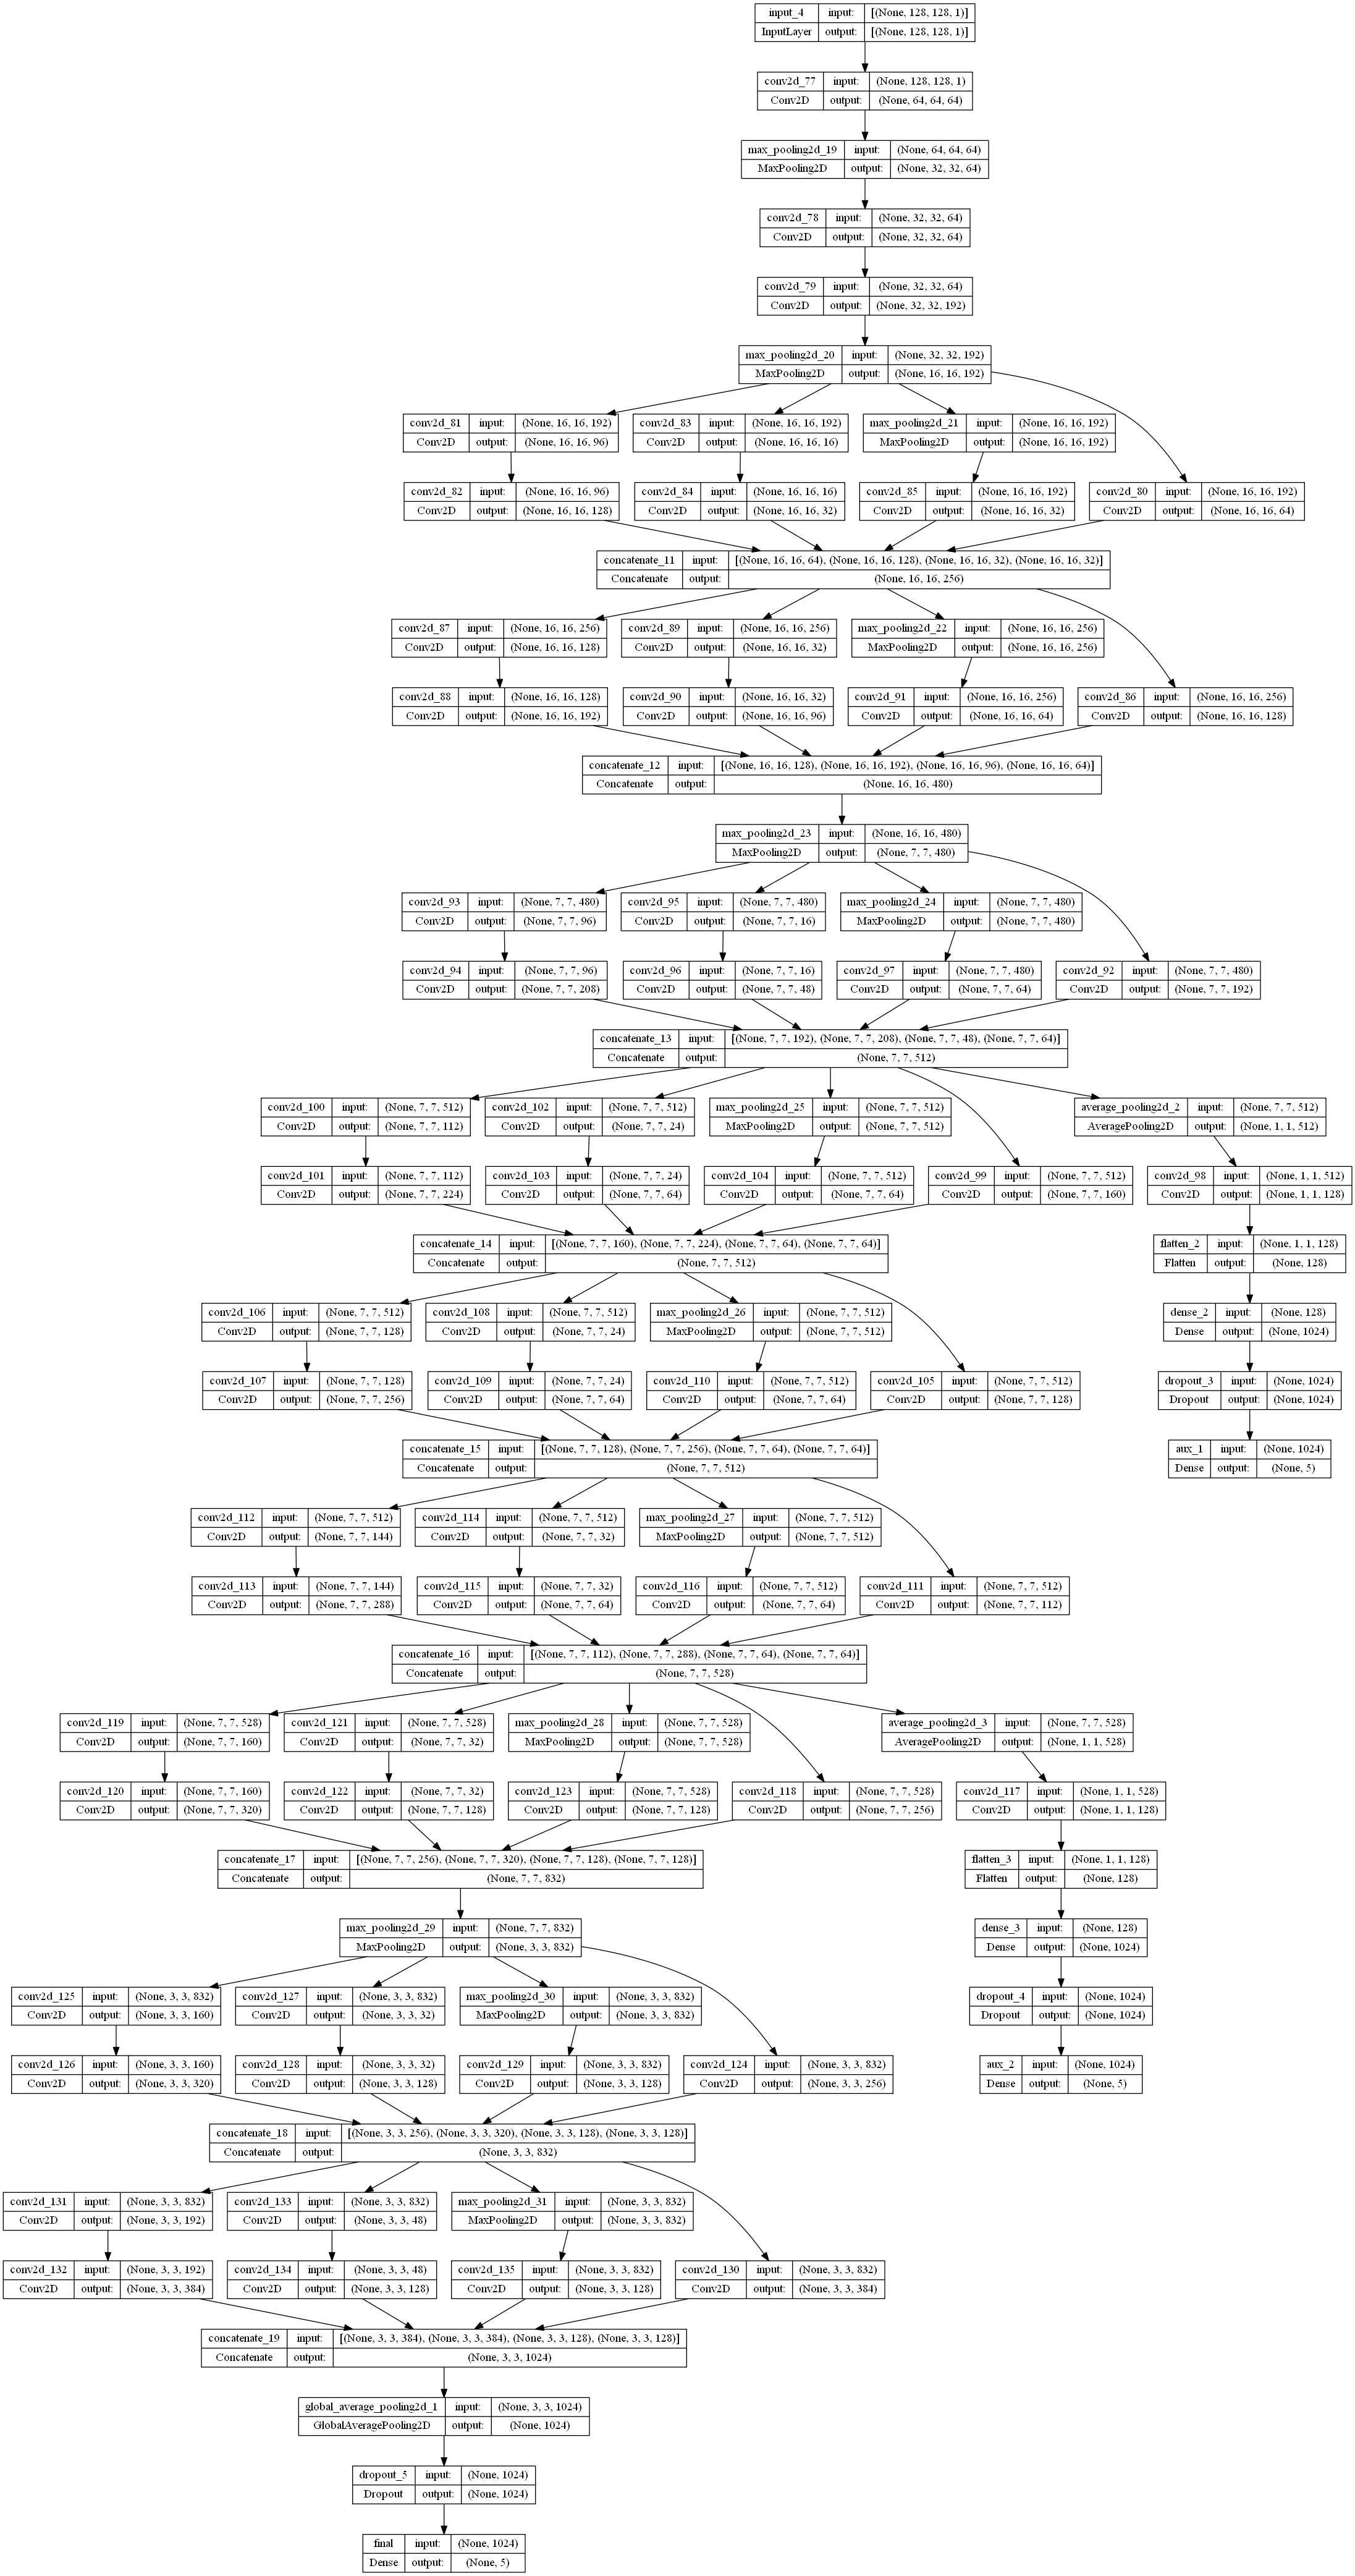

In [61]:
from tensorflow.keras.utils import plot_model

plot_model(googleNet, to_file='model.png')
plot_model(googleNet, to_file='model_shape.png', show_shapes=True)

In [62]:
googleNet.compile(
        optimizer='adam',
        # loss="sparse_categorical_crossentropy",
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

### 콜백 설정

In [63]:
# 콜백 설정
from keras.callbacks import EarlyStopping, ModelCheckpoint

outDir = './cheakpoint/googleNet/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{final_accuracy:.4f}.h5'

def get_callbacks(patience = 50): 
    with tf.device('/gpu:0'):
        earlystop = EarlyStopping(monitor='final_accuracy', min_delta=0.0001, patience=patience)
        model_checkpoint = ModelCheckpoint(model_names, monitor='final_accuracy', verbose=1, save_best_only=True, period = 1)
    
        # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
        callbacks = [model_checkpoint]
        return callbacks

# 학습하기

In [64]:
callbacks = get_callbacks()

with tf.device('/device:GPU:0'):
    models_hist = googleNet.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCH,
        validation_data=(X_val, y_val),
        callbacks = [callbacks]
    )

Epoch 1/100
590/590 [==============================] - ETA: 0s - loss: 2.1591 - final_loss: 0.7264 - aux_1_loss: 0.7166 - aux_2_loss: 0.7161 - final_accuracy: 0.8030 - aux_1_accuracy: 0.8032 - aux_2_accuracy: 0.8031
Epoch 1: final_accuracy improved from -inf to 0.80300, saving model to ./cheakpoint/googleNet\weights-0.8030.h5
590/590 [==============================] - 67s 109ms/step - loss: 2.1591 - final_loss: 0.7264 - aux_1_loss: 0.7166 - aux_2_loss: 0.7161 - final_accuracy: 0.8030 - aux_1_accuracy: 0.8032 - aux_2_accuracy: 0.8031 - val_loss: 2.1259 - val_final_loss: 0.7069 - val_aux_1_loss: 0.7087 - val_aux_2_loss: 0.7103 - val_final_accuracy: 0.8062 - val_aux_1_accuracy: 0.8062 - val_aux_2_accuracy: 0.8062
Epoch 2/100
590/590 [==============================] - ETA: 0s - loss: 2.1373 - final_loss: 0.7119 - aux_1_loss: 0.7127 - aux_2_loss: 0.7127 - final_accuracy: 0.8044 - aux_1_accuracy: 0.8044 - aux_2_accuracy: 0.8044
Epoch 2: final_accuracy improved from 0.80300 to 0.80442, saving

KeyboardInterrupt: 

# 결과 시각화 하기

In [39]:
# 학습 된 모델의 학습 과정 시각화
import matplotlib.pyplot as plt
def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['final_accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_final_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

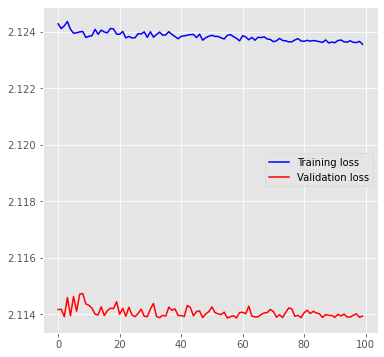

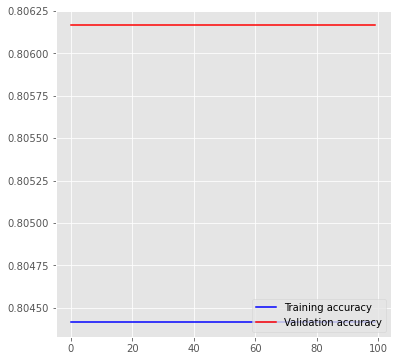

384/384 [==============================] - 12s 31ms/step - loss: 2.1139 - final_loss: 0.7046 - aux_1_loss: 0.7046 - aux_2_loss: 0.7046 - final_accuracy: 0.8062 - aux_1_accuracy: 0.8062 - aux_2_accuracy: 0.8062
[2.1139371395111084, 0.7046472430229187, 0.7046450972557068, 0.7046450972557068, 0.8061648607254028, 0.8061648607254028, 0.8061648607254028]


In [43]:
plot_model__hist(models_hist)
loss = googleNet.evaluate(X_val, y_val)
# print("multi_model의 정확도: {:5.2f}%".format(100*loss))
print(loss)

# 모델 불러와서 confusion matrix 그리기

In [44]:
tf.keras.backend.clear_session()

In [45]:
# 모델 불러오기
reconstructed_model = keras.models.load_model("./cheakpoint/googleNet/weights-0.8044.h5")

In [46]:
# 예측값 얻기
with tf.device('cpu:0'):
    y_pred = reconstructed_model.predict(X_test)

778/778 [==============================] - 82s 105ms/step


In [47]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y= []
for val in y_test:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y.append(cnt)

In [52]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y_pred = []
for val in y_pred:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [50]:
# 최종 정확도 산출
with tf.device('/cpu:0'):
    score = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

778/778 [==============================] - 75s 97ms/step - loss: 2.1134 - final_loss: 0.7046 - aux_1_loss: 0.7044 - aux_2_loss: 0.7044 - final_accuracy: 0.8057 - aux_1_accuracy: 0.8057 - aux_2_accuracy: 0.8057
정답률 =  0.7046324014663696 loss= 2.1133716106414795


### confusion matrix 그리기

In [51]:
# 개수 버전
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [24895, 0]

In [ ]:
# percentile 버전
total = np.sum(cm2, axis=1)
cm2_percentile = cm2/total[:,None]
sns.heatmap(np.round(cm2_percentile,3), annot = True, cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y, new_y_pred)

In [ ]:
# classification_report 그리기
from sklearn.metrics import classification_report
target_names = ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q']
print(classification_report(new_y, new_y_pred, target_names=target_names))